# Introduction To NLP Fundamentals In TensorFlow

NLP (Natural Language Processing) has the goal of deriving information out of natural language (could be sequences of text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Get Helper Functions:

In [1]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Get A Text Dataset:

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labeled as disaster or not disaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

## Visualizing A Text Dataset:

To visualize our text samples, we first have to read them in; one way to do so would be to use Python: https:/realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use Pandas...

In [2]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [4]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [3]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df), len(train_df) + len(test_df)

(7613, 3263, 10876)

In [4]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df) - 5) # Create random indexes not highter than the total number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index + 5].itertuples():
    _, text, target = row
    print(f'Target: {target}', '(real disaster)' if target > 0 else '(not real disaster)')
    print(f'Text:\n{text}\n')
    print('---\n')

Target: 1 (real disaster)
Text:
Army sources say 12 persons on board including a team of doctors die in helicopter crashed near Mansehra. weather seems to be cause of crash

---

Target: 0 (not real disaster)
Text:
@Demetae12 yes i want to be the new blight leader

---

Target: 1 (real disaster)
Text:
Wreckage is MH370: Najib
http://t.co/iidKC0jSBx #MH370 #najibrazak #MalaysiaAirlines

---

Target: 0 (not real disaster)
Text:
@spinningbot Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.

---

Target: 1 (real disaster)
Text:
Suffield Alberta Accident https://t.co/bPTmlF4P10

---



### ⚠️ Update - Clean Text:

Mojibake is the garbled or gibberish text that is the result of text being decoded using an unintended character encoding. The result is a systematic replacement of symbols with completely unrelated ones, often from a different writing system. This display may include the generic replacement character (�) in places where the binary representation is considered invalid. A replacement can also involve multiple consecutive symbols, as viewed in one encoding, when the same binary code constitutes one symbol in the other encoding.

See https://en.wikipedia.org/wiki/Mojibake for more info.

Text models run into problems if their vocabularies include mojibake characters. This includes being unable to save such models and their histories.

We do not want mojibake characters in our data, so it's generally advised to clean up your text data before doing anything else with it.

In [5]:
from ftfy import fix_text #ftfy = "Fixes text for you"
import re

def clean_text(s):
    s = fix_text(str(s))  # repair mojibake
    s = re.sub(r"[^\x00-\x7F]+", "", s)  # strip non-ASCII if you want it ultra-clean
    return s

In [6]:
train_df_shuffled["clean_text"] = train_df_shuffled["text"].apply(clean_text)
train_df_shuffled.head()

,id,keyword,location,text,target,clean_text
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,So you have a new weapon that can cause un-ima...
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,The f$&@ing things I do for #GISHWHES Just got...
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,DT @georgegalloway: RT @Galloway4Mayor: The Co...
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,Aftershock back to school kick off was great. ...
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,in response to trauma Children of Addicts deve...


### Split Data Into Training And Validation Sets

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['clean_text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size = 0.1, # Use 10% of training data for validation split
                                                                            random_state = 42)

In [15]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [16]:
len(train_df_shuffled)

7613

In [17]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting Text Into Numbers:

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - Direct Mapping of token (a token could be a word or a character) to number
* Embedding - Create a matrix of feature vectors for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text Vectorization (Tokenization):

In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization #Also no longer experimental, and now implemented directly into tf.keras.layers.TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens = None, # How many words in the vocabulary (automatically add <OOV> (Out Of Vocabulary) for rare words); None = No vocab limit
                                    standardize='lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    ngrams = None, # Create groups of n-words?
                                    output_mode = 'int', # How to map tokens to numbers
                                    output_sequence_length = None, # How long do you want your sequences to be?
                                    pad_to_max_tokens = True) # Cannot use pad_to_max_tokens without setting max_tokens

ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens = None, # How many words in the vocabulary (automatically add <OOV> (Out Of Vocabulary) for rare words); None = No vocab limit
                                    standardize='lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    ngrams = None, # Create groups of n-words?
                                    output_mode = 'int', # How to map tokens to numbers
                                    output_sequence_length = None) # How long do you want your sequences to be?

In [20]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [21]:
len(train_sentences[0].split())

7

In [22]:
# Find the average number of tokens (words) in the training 
round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))

15

In [10]:
# Set up text vectorization variables
max_vocab_length = 10000 # Max number of words to have in our vocabulary
max_length = 15 # Max length our sequences will be (e.g. how many words from a Tweed does a model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)

In [11]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences) #Only call this on the training data, as this is similar to fitting a scaler

In [12]:
# Create a sample sentence and tokenize it
sample_sentence = 'There\'s a flood in my street!'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[265,   3, 232,   4,  13, 699,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [26]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
    \n\nVectorized version:')
text_vectorizer([random_sentence])

Original text:
 @missleylaha I didn't get to buy one after the last London show because the fire alarm went off and everyone had to be evacuated. hahahaha    

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,    8,  491,   51,    5, 1152,   61,   43,    2,  138, 1195,
         434,  151,    2,   40]])>

In [27]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # Get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # Get the most common words
bottom_5_words = words_in_vocab[-5:] # Get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}') #[UNK] = Unknown, an OOV word
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
5 least common words: [np.str_('offloading'), np.str_('offline'), np.str_('offing'), np.str_('officialtjonez'), np.str_('officialrealrap')]


In [28]:
#Inspect text vectorizer's vocabulary for mojibake characters
with open("vocab.txt", "w", encoding="utf-8") as f:
    for token in text_vectorizer.get_vocabulary():
        f.write(token + "\n")

### Creating An Embedding Using An Embedding Layer:

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = The size of our vocabulary
* `output_dim` = The size of the output embedding vector; for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = Length of the sequences being passed to the embedding layer

In [11]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, # Set input shape
                            output_dim = 128,
                            input_length = max_length) # How long is each input
embedding

c:\Users\Jake\Documents\Udemy_Courses\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding, built=False>

In [30]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
    \n\nEmbedded version:')

    # Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence])) #You have to tokenize text before you can embed it!
sample_embed

Original text:
 Robert Gagnon reviews the catastrophe of imposing same-sex marriage and how Christians should respond http://t.co/HIpklxpHnp    

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01235469, -0.04947088,  0.01497796, ..., -0.00978731,
          0.04142335,  0.02874133],
        [ 0.01429923, -0.00576341, -0.01780664, ...,  0.04119821,
         -0.03848354,  0.02695232],
        [-0.02753409,  0.01611726,  0.0110411 , ..., -0.00046476,
          0.00014242,  0.01766464],
        ...,
        [-0.04871955,  0.02276951, -0.02469331, ..., -0.01929652,
          0.01360993,  0.04111766],
        [ 0.01584754, -0.01795   , -0.00646972, ..., -0.01082891,
          0.02762295, -0.02293072],
        [ 0.01429923, -0.00576341, -0.01780664, ...,  0.04119821,
         -0.03848354,  0.02695232]]], shape=(1, 15, 128), dtype=float32)>

In [32]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-1.23546943e-02, -4.94708791e-02,  1.49779581e-02,  4.18032669e-02,
        -3.55048999e-02,  2.32441090e-02, -3.29707861e-02, -3.42517719e-02,
         1.96679272e-02,  3.32003124e-02,  3.20686810e-02, -1.44680738e-02,
        -5.68659231e-03, -4.34891097e-02,  3.59890126e-02,  5.92110306e-03,
        -2.87886020e-02,  4.30365540e-02,  2.02402957e-02, -1.33707747e-02,
         4.95632030e-02, -4.14776206e-02,  1.53304823e-02, -4.11256403e-03,
        -5.30027226e-03,  6.06944412e-03, -2.02152375e-02, -6.50589541e-03,
        -2.01933272e-02,  4.76277992e-03, -3.52933407e-02,  1.25795491e-02,
         1.56661384e-02, -1.22243762e-02,  1.94840506e-03, -1.52528770e-02,
         3.96339633e-02, -1.40995979e-02,  3.87753583e-02, -8.93265009e-03,
        -4.57513705e-02, -4.36799899e-02,  8.76177475e-03,  3.37233059e-02,
        -4.55322862e-02,  3.24209593e-02, -1.85504332e-02,  5.94873354e-03,
         6.71697780e-03,  4.99106310e-0

## Modeling A Text Dataset (Running A Series Of Experiments):

Now that we've got a way to turn our text sequences into numbers, it's time to start building a series of modeling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (Baseline); this is from SKLearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward nerual network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: Tensorflow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modeling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0 - Getting A Baseline:

As with all machine learning modeling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF_IDF formula to convert our words to numbers.

🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0 = Pipeline([
    ('tfidi', TfidfVectorizer()), # Convert words to numbers using tfidf
    ('clf', MultinomialNB()) # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

,steps,"[('tfidi', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [34]:
# Save baseline model using joblib
from joblib import dump, load
from pathlib import Path
subfolder_path = Path('NLP_Models')
subfolder_path.mkdir(parents = True, exist_ok = True)
model_0_file_path = subfolder_path / 'model_0.joblib'
dump(model_0, model_0_file_path)

['NLP_Models\\model_0.joblib']

In [39]:
# Load baseline model using joblib
from joblib import dump, load
model_0 = load('NLP_Models/model_0.joblib')

In [36]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score * 100:.2f}%') #Our baseline is performing better than guessing

Our baseline model achieves an accuracy of: 79.53%


In [37]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating An Evaluation Function For Our Model Experiments:

We could evaluate all of our models' predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our models' predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-Score

For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [14]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall, and f1-score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall, and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    model_results = {'accuracy': model_accuracy,
                     'precision': model_precision,
                     'recall': model_recall,
                     'f1': model_f1}
    return model_results

In [39]:
# Get baseline results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.52755905511812,
 'precision': 0.8149848016893324,
 'recall': 0.7952755905511811,
 'f1': 0.788715433016065}

In [40]:
# Save baseline results
import pickle
with open('NLP_Models/baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

In [43]:
# Load baseline results
import pickle
with open('NLP_Models/baseline_results.pkl', 'rb') as f:
    baseline_results = pickle.load(f)

### Model 1 - A Simple Dense Model:

In [16]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [43]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = tf.string) # Inputs are 1-dimensional strings
x = text_vectorizer(inputs) # Turn the input text into numbers
x = embedding(x) # Create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # Condense the feature vextor for each token to one vector
outputs = layers.Dense(1, activation = 'sigmoid')(x) # Create the output layer; want binary outputs, so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_dense')

In [44]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Compile model
model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [46]:
# Fit the model
model_1_history = model_1.fit(x = train_sentences,
                              y = train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20251013-112406
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.6888 - loss: 0.6096 - val_accuracy: 0.7651 - val_loss: 0.5335
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8177 - loss: 0.4444 - val_accuracy: 0.7874 - val_loss: 0.4698
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8591 - loss: 0.3494 - val_accuracy: 0.7913 - val_loss: 0.4600
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8883 - loss: 0.2871 - val_accuracy: 0.7913 - val_loss: 0.4624
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9113 - loss: 0.2406 - val_accuracy: 0.7927 - val_loss: 0.4847


In [13]:
#Let's define functions to save/load a model and its corresponding history

import os
import pickle
import tensorflow as tf

def save_model_and_history(model, history, model_name, base_dir = "NLP_Models"):
    """
    Save a Keras model and its full History object to a subfolder.

    Args:
        model (tf.keras.Model): Trained Keras model to save.
        history (tf.keras.callbacks.History): History object from model.fit().
        model_name (str): Name for the model (used in filenames).
        base_dir (str): Directory where models are stored.
    """
    os.makedirs(base_dir, exist_ok=True)

    # Save model in .keras format
    model_path = os.path.join(base_dir, f"{model_name}.keras")
    model.save(model_path)

    # Save full History object
    history_path = os.path.join(base_dir, f"{model_name}_history.pkl")
    with open(history_path, "wb") as f:
        pickle.dump(history, f)

    print(f"✅ Saved model to {model_path}")
    print(f"✅ Saved full History object to {history_path}")


def load_model_and_history(model_name, base_dir = "NLP_Models"):
    """
    Reload a Keras model and its full History object.

    Returns:
        model (tf.keras.Model), history (tf.keras.callbacks.History)
    """
    model_path = os.path.join(base_dir, f"{model_name}.keras")
    history_path = os.path.join(base_dir, f"{model_name}_history.pkl")

    model = tf.keras.models.load_model(model_path)
    with open(history_path, "rb") as f:
        history = pickle.load(f)

    print(f"✅ Loaded model from {model_path}")
    print(f"✅ Loaded History object from {history_path}")
    return model, history

In [48]:
#Save model and its hstory
save_model_and_history(model_1, model_1_history, 'model_1')

✅ Saved model to NLP_Models\model_1.keras
✅ Saved full History object to NLP_Models\model_1_history.pkl


In [19]:
#Load model and its history
model_1, model_1_history = load_model_and_history('model_1')

✅ Loaded model from NLP_Models\model_1.keras
✅ Loaded History object from NLP_Models\model_1_history.pkl


In [50]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7927 - loss: 0.4847


[0.4847443699836731, 0.7926509380340576]

In [51]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[2.70161659e-01],
       [8.31235051e-01],
       [9.97959912e-01],
       [8.21642876e-02],
       [9.69637632e-02],
       [9.32117283e-01],
       [9.08747435e-01],
       [9.92574751e-01],
       [9.51628447e-01],
       [1.81639001e-01],
       [1.17304422e-01],
       [6.26692474e-01],
       [3.37641910e-02],
       [1.82178199e-01],
       [4.09197947e-03],
       [9.94345546e-02],
       [3.18792462e-02],
       [3.58542129e-02],
       [1.59232527e-01],
       [4.08620805e-01],
       [9.00360286e-01],
       [4.38546091e-02],
       [3.90297502e-01],
       [6.07940331e-02],
       [9.61408436e-01],
       [9.99012291e-01],
       [2.42339578e-02],
       [4.53821793e-02],
       [2.20445450e-02],
       [1.82875693e-01],
       [4.81454998e-01],
       [1.91016451e-01],
       [5.57691753e-01],
       [1.63553804e-01],
       [4.69201267e-01],
       [4.52296548e-02],
       [9.93403792e-01],
       [9.66061130e-02],
       [3.08449827e-02],
       [9.98671591e-01],


In [52]:
model_1_pred_probs.shape

(762, 1)

In [53]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.27016166], dtype=float32)

In [54]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.27016166],
       [0.83123505],
       [0.9979599 ],
       [0.08216429],
       [0.09696376],
       [0.9321173 ],
       [0.90874743],
       [0.99257475],
       [0.95162845],
       [0.181639  ]], dtype=float32)

In [55]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [56]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 79.26509186351706,
 'precision': 0.8008492102900203,
 'recall': 0.7926509186351706,
 'f1': 0.7888220986443327}

In [57]:
# Looks like our baseline is outperforming our first deep learning model...
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

In [58]:
# Save model_1's results
import pickle
with open('NLP_Models/model_1_results.pkl', 'wb') as f:
    pickle.dump(model_1_results, f)

In [20]:
# Load model_1's results
import pickle
with open('NLP_Models/model_1_results.pkl', 'rb') as f:
    model_1_results = pickle.load(f)

## Visualizing Learned Embeddings:

In [60]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000,
 ['',
  '[UNK]',
  np.str_('the'),
  np.str_('a'),
  np.str_('in'),
  np.str_('to'),
  np.str_('of'),
  np.str_('and'),
  np.str_('i'),
  np.str_('is')])

In [61]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [63]:
# Get the weight matrix of the embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()
embed_weights

[array([[ 0.01979411, -0.02748405,  0.01476507, ..., -0.05035143,
          0.02241759, -0.06970292],
        [-0.00094471, -0.02079169, -0.03220532, ...,  0.02573896,
         -0.04825349,  0.0118851 ],
        [-0.0329676 ,  0.01706992, -0.05896877, ..., -0.02766563,
         -0.03854199, -0.03844907],
        ...,
        [ 0.05122425,  0.02726864,  0.08529446, ...,  0.03719155,
          0.02835492,  0.03357959],
        [-0.00879628, -0.02991962, -0.01661368, ...,  0.00758013,
         -0.02489713, -0.02745431],
        [-0.02960229, -0.06023264, -0.02526821, ..., -0.06713734,
         -0.05781968, -0.04116021]], shape=(10000, 128), dtype=float32)]

In [65]:
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape) # Same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


In [66]:
embed_weights

array([[ 0.01979411, -0.02748405,  0.01476507, ..., -0.05035143,
         0.02241759, -0.06970292],
       [-0.00094471, -0.02079169, -0.03220532, ...,  0.02573896,
        -0.04825349,  0.0118851 ],
       [-0.0329676 ,  0.01706992, -0.05896877, ..., -0.02766563,
        -0.03854199, -0.03844907],
       ...,
       [ 0.05122425,  0.02726864,  0.08529446, ...,  0.03719155,
         0.02835492,  0.03357959],
       [-0.00879628, -0.02991962, -0.01661368, ...,  0.00758013,
        -0.02489713, -0.02745431],
       [-0.02960229, -0.06023264, -0.02526821, ..., -0.06713734,
        -0.05781968, -0.04116021]], shape=(10000, 128), dtype=float32)

Now that we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [67]:
# Create embedding files (we got this from TensorFlow's word embedding documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding = 'utf-8')
out_m = io.open('metadata.tsv', 'w', encoding = 'utf-8')

for index, word in enumerate(words_in_vocab):
    if index == 0:
        continue # Skip 0, it's padding
    vec = embed_weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    out_m.write(word + '\n')
out_v.close()
out_m.close()

In [68]:
# Download files from Colab (if using) to projector
try:
    from google.colab import files
    files.download('vectors.tsv')
    files.download('metadata.tsv')
except Exception:
    pass

Downloading the files above, we can visualize them using http://projector.tensorflow.org/ and clicking the "load" button on the left hand side.

📖 **Resources:** If you'd like to know more about embeddings, I'd encourage you to check out:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNN's):

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

📖 **Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modeling lecture: https://youtu.be/qjrad0V0uJE
- Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's "The Unreasonable Effectiveness of Recurrent Neural Networks": http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2 - LSTM:

LSTM = Long Short-Term Memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (layer probability)

In [71]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = 'string')
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(units = 64, return_sequences = True)(x) # When you're stacking RNN cells together, you need to set return_sequences = True
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation = 'relu')(x)
#print(x.shape)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'model_2_LSTM')

In [72]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Compile the model
model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [74]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20251013-121434
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.9158 - loss: 0.2261 - val_accuracy: 0.7848 - val_loss: 0.5822
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.9372 - loss: 0.1590 - val_accuracy: 0.7677 - val_loss: 0.8036
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.9499 - loss: 0.1331 - val_accuracy: 0.7795 - val_loss: 0.7509
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9588 - loss: 0.1061 - val_accuracy: 0.7717 - val_loss: 0.8901
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9654 - loss: 0.0861 - val_accuracy: 0.7690 - val_loss: 0.8538


In [75]:
#Save model and its history
save_model_and_history(model_2, model_2_history, 'model_2')

✅ Saved model to NLP_Models\model_2.keras
✅ Saved full History object to NLP_Models\model_2_history.pkl


In [21]:
#Load model and its history
model_2, model_2_history = load_model_and_history('model_2')

✅ Loaded model from NLP_Models\model_2.keras
✅ Loaded History object from NLP_Models\model_2_history.pkl


In [77]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


array([[1.0915534e-02],
       [9.0068775e-01],
       [9.9980175e-01],
       [9.9431574e-02],
       [8.1355922e-04],
       [9.9942094e-01],
       [6.1192381e-01],
       [9.9989516e-01],
       [9.9979168e-01],
       [2.3320033e-01]], dtype=float32)

In [78]:
# Convert model_2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
# Calculate model 2 results
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7717390408616506,
 'recall': 0.7690288713910761,
 'f1': 0.766385677090764}

In [82]:
baseline_results

{'accuracy': 79.52755905511812,
 'precision': 0.8149848016893324,
 'recall': 0.7952755905511811,
 'f1': 0.788715433016065}

In [83]:
# Save model_2's results
import pickle
with open('NLP_Models/model_2_results.pkl', 'wb') as f:
    pickle.dump(model_2_results, f)

In [22]:
# Load model_2's results
import pickle
with open('NLP_Models/model_2_results.pkl', 'rb') as f:
    model_2_results = pickle.load(f)

### Model 3 - GRU:

Another popular and effective RNN component is the GRU or Gated Recurrent Unit.

The GRU cell has similar features to an LSTM cell, but has less parameters.

In [93]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.GRU(64, return_sequences = True)(x) # If you want to stack recurrent layers on top of each other, you need return_sequences = True
#print(x.shape)
#x = layers.LSTM(42, return_sequences = True)(x)
#print(x.shape)
#x = layers.GRU(99)(x)
#print(x.shape)
#x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_GRU')

In [94]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Compile the model
model_3.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [96]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20251013-135410
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.9384 - loss: 0.1613 - val_accuracy: 0.7808 - val_loss: 0.8394
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.9666 - loss: 0.0856 - val_accuracy: 0.7769 - val_loss: 0.8594
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 46s 126ms/step - accuracy: 0.9717 - loss: 0.0722 - val_accuracy: 0.7730 - val_loss: 1.0624
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.9739 - loss: 0.0593 - val_accuracy: 0.7651 - val_loss: 1.0933
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step - accuracy: 0.9777 - loss: 0.0533 - val_accuracy: 0.7638 - val_loss: 1.3940


In [97]:
#Save model and its history
save_model_and_history(model_3, model_3_history, 'model_3')

✅ Saved model to NLP_Models\model_3.keras
✅ Saved full History object to NLP_Models\model_3_history.pkl


In [23]:
#Load model and its history
model_3, model_3_history = load_model_and_history('model_3')

✅ Loaded model from NLP_Models\model_3.keras
✅ Loaded History object from NLP_Models\model_3_history.pkl


In [99]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


array([[1.4747663e-04],
       [8.8291055e-01],
       [9.9994141e-01],
       [7.7773528e-03],
       [5.6314511e-05],
       [9.9981678e-01],
       [9.2783648e-01],
       [9.9997550e-01],
       [9.9993467e-01],
       [2.1170835e-01]], dtype=float32)

In [100]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [102]:
# Calculate model_3 results
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 76.37795275590551,
 'precision': 0.768889469729147,
 'recall': 0.7637795275590551,
 'f1': 0.7599542443739118}

In [104]:
baseline_results

{'accuracy': 79.52755905511812,
 'precision': 0.8149848016893324,
 'recall': 0.7952755905511811,
 'f1': 0.788715433016065}

In [105]:
# Save model_3's results
import pickle
with open('NLP_Models/model_3_results.pkl', 'wb') as f:
    pickle.dump(model_3_results, f)

In [24]:
# Load model_3's results
import pickle
with open('NLP_Models/model_3_results.pkl', 'rb') as f:
    model_3_results = pickle.load(f)

### Model 4 - Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however, a bidirectional RNN goes from right to left as well as left to right.

In [26]:
# Build a bidirectional RNN in Tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = 'string')
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
# print(x.shape)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = 'model_4_bidirectional')

In [27]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,625 (5.17 MB)

 Trainable params: 1,354,625 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile model
model_4.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [30]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20251014-125001
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.7406 - loss: 0.5145 - val_accuracy: 0.7822 - val_loss: 0.4681
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.8716 - loss: 0.3147 - val_accuracy: 0.7835 - val_loss: 0.4732
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.9238 - loss: 0.2012 - val_accuracy: 0.7782 - val_loss: 0.5953
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9517 - loss: 0.1366 - val_accuracy: 0.7507 - val_loss: 0.6828
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9666 - loss: 0.0989 - val_accuracy: 0.7493 - val_loss: 0.6742


In [31]:
#Save model and its history
save_model_and_history(model_4, model_4_history, 'model_4')

✅ Saved model to NLP_Models\model_4.keras
✅ Saved full History object to NLP_Models\model_4_history.pkl


In [25]:
#Load model and its history
model_4, model_4_history = load_model_and_history('model_4')

✅ Loaded model from NLP_Models\model_4.keras
✅ Loaded History object from NLP_Models\model_4_history.pkl


In [33]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step


array([[0.40040278],
       [0.92470753],
       [0.9998386 ],
       [0.11668226],
       [0.00174175],
       [0.99880344],
       [0.8329826 ],
       [0.999871  ],
       [0.99948454],
       [0.09093419]], dtype=float32)

In [34]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [35]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true = val_labels,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 74.93438320209974,
 'precision': 0.7489845053528059,
 'recall': 0.7493438320209974,
 'f1': 0.7483475363447356}

In [36]:
# Save model_4's results
import pickle
with open('NLP_Models/model_4_results.pkl', 'wb') as f:
    pickle.dump(model_4_results, f)

In [26]:
# Load model_4's results
import pickle
with open('NLP_Models/model_4_results.pkl', 'rb') as f:
    model_4_results = pickle.load(f)

## Convolutional Neural Networks For Text (And Other Types Of Sequences):

We've used CNNs for images, but images are typically 2D (height x width)... however, our text data is 1D.

Previously, we've used Conv2D for our image data, but now, we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5 - Conv1D:

For different explanations of parameters, see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D, but can relate to 1D data)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [31]:
# Test out our embedding layer, Conv1D layer, and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(['this is a test sentence'])) # Turn target sequence into embedding
conv_1d = layers.Conv1D(filters = 64,
                        kernel_size = 5, # This is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides = 1, # Default
                        activation = 'relu',
                        padding = 'same') # Default = "valid", the output is smaller than the input shape; "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # Pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # Equivalent to 'get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [32]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0075331 , -0.03781778,  0.02251978, ..., -0.02076472,
         -0.01683049,  0.03534963],
        [-0.04706695,  0.01540246, -0.01132745, ...,  0.01102326,
         -0.00184242,  0.04160508],
        [-0.01153081, -0.00556096, -0.00217788, ...,  0.00045257,
         -0.01541167,  0.02427849],
        ...,
        [-0.02594353, -0.0490216 , -0.04510522, ..., -0.04708985,
         -0.0454247 , -0.0126932 ],
        [-0.02594353, -0.0490216 , -0.04510522, ..., -0.04708985,
         -0.0454247 , -0.0126932 ],
        [-0.02594353, -0.0490216 , -0.04510522, ..., -0.04708985,
         -0.0454247 , -0.0126932 ]]], shape=(1, 15, 128), dtype=float32)>

In [33]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[0.01545168, 0.        , 0.01474286, 0.        , 0.        ,
         0.        , 0.02848883, 0.00504679, 0.01103796, 0.0392396 ,
         0.01851095, 0.        , 0.02148256, 0.        , 0.        ,
         0.02645561, 0.        , 0.        , 0.        , 0.00333169,
         0.01006186, 0.00038027, 0.01473525, 0.00075843, 0.        ,
         0.        , 0.01824644, 0.01439313, 0.        , 0.        ,
         0.        , 0.        , 0.00179365, 0.03055096, 0.00334603,
         0.0139675 , 0.05361873, 0.01445752, 0.        , 0.        ,
         0.03005372, 0.03864149, 0.        , 0.        , 0.        ,
         0.05803151, 0.02362299, 0.01925371, 0.01017536, 0.01619773,
         0.02446114, 0.01196079, 0.        , 0.0086443 , 0.        ,
         0.        , 0.01219942, 0.        , 0.0275529 , 0.        ,
         0.        , 0.00191495, 0.        , 0.01247732],
        [0.04538641, 0.00251151, 0.03289923, 0.00885806, 0.00

In [34]:
max_pool_output

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.04538641, 0.02309834, 0.03289923, 0.04564777, 0.03338286,
        0.05733926, 0.03637591, 0.03158654, 0.02644704, 0.05271976,
        0.06601486, 0.02550231, 0.02148256, 0.07181284, 0.03145111,
        0.03456741, 0.01978734, 0.03701997, 0.06789715, 0.02236146,
        0.04205315, 0.05406928, 0.05026418, 0.02383943, 0.02636207,
        0.07223906, 0.0423268 , 0.04834273, 0.03347656, 0.0413045 ,
        0.05102422, 0.07207884, 0.04368678, 0.04733327, 0.04909213,
        0.07988367, 0.05361873, 0.02046183, 0.03563553, 0.02900471,
        0.03005372, 0.03864149, 0.02475639, 0.03145491, 0.04645169,
        0.05803151, 0.0270081 , 0.02724384, 0.01017536, 0.04626729,
        0.07447246, 0.06578441, 0.00182475, 0.0086443 , 0.03207684,
        0.04578637, 0.04705791, 0.03938043, 0.0275529 , 0.01169986,
        0.01308929, 0.03650586, 0.05487594, 0.04012313]], dtype=float32)>

In [35]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, activation = 'relu', padding = 'valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x - layers.Dense(64, activation = 'relu)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_Conv1D')

# Compile Conv1D
model_5.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 11, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,089 (5.04 MB)

 Trainable params: 1,321,089 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20251016-112745
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.7270 - loss: 0.5451 - val_accuracy: 0.7782 - val_loss: 0.4753
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.8675 - loss: 0.3286 - val_accuracy: 0.7900 - val_loss: 0.4678
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.9270 - loss: 0.2064 - val_accuracy: 0.7822 - val_loss: 0.5558
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.9539 - loss: 0.1337 - val_accuracy: 0.7651 - val_loss: 0.6266
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 39s 123ms/step - accuracy: 0.9699 - loss: 0.0953 - val_accuracy: 0.7651 - val_loss: 0.6690


In [37]:
#Save model and its history
save_model_and_history(model_5, model_5_history, 'model_5')

✅ Saved model to NLP_Models\model_5.keras
✅ Saved full History object to NLP_Models\model_5_history.pkl


In [27]:
#Load model and its history
model_5, model_5_history = load_model_and_history('model_5')

✅ Loaded model from NLP_Models\model_5.keras
✅ Loaded History object from NLP_Models\model_5_history.pkl


In [39]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[0.77784234],
       [0.9753945 ],
       [0.99917513],
       [0.04491466],
       [0.01082306],
       [0.9979988 ],
       [0.8893491 ],
       [0.99954605],
       [0.99976164],
       [0.36310348]], dtype=float32)

In [40]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [41]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 76.50918635170603,
 'precision': 0.765325307490926,
 'recall': 0.7650918635170604,
 'f1': 0.7637474572934757}

In [44]:
baseline_results

{'accuracy': 79.52755905511812,
 'precision': 0.8149848016893324,
 'recall': 0.7952755905511811,
 'f1': 0.788715433016065}

In [42]:
# Save model_5's results
import pickle
with open('NLP_Models/model_5_results.pkl', 'wb') as f:
    pickle.dump(model_5_results, f)

In [28]:
# Load model_5's results
import pickle
with open('NLP_Models/model_5_results.pkl', 'rb') as f:
    model_5_results = pickle.load(f)

## Model 6 - TensorFlow Hub Pretrained Sentence Encoder:

Now that we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [49]:
sample_sentence

"There's a flood in my street!"

In [47]:
import tensorflow_hub as hub
embed = hub.load('https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2')
embed_samples = embed([sample_sentence,
                       'When you call the universal sentence encoder on a sentence, it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878052 -0.012715    0.03971541  0.08827759
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865344 -0.04209307  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985926 -0.04063615 -0.01292093
 -0.04666383  0.05630299 -0.03949255  0.00517682  0.02495827 -0.0701444
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998648 -0.10361788 -0.05195373  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [48]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157025,  0.02485911,  0.02878052, ..., -0.00186124,
         0.02315822, -0.01485021],
       [ 0.03596691, -0.08579467, -0.01152743, ..., -0.03414335,
         0.02816024, -0.00878945]], shape=(2, 512), dtype=float32)>

In [50]:
embed_samples[0].shape

TensorShape([512])

In [51]:
# Create a Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer('https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2',
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'USE')

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    # layers.Dense(64, activation = 'relu')
    layers.Dense(1, activation = 'sigmoid')
], name = 'model_6_USE')

# Compile
model_6.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrice = ['accuracy'])

model_6.summary()

# Update: You can no longer create sequential models with layers from TensorFlow Hub. All models involving these layers must be developed using the functional API.
# And the feature extractor must be wrapped in a class that stores the url without handles and makes the custom layer registerable
# Let's use a remix of the HubFeatureExtractor class created in module 4, but this time, built for binary text classification using the USE model

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x000001EBE98A78D0> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [17]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="HubTextEncoder")
class HubTextEncoder(layers.Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.hub_url = hub_url
        self.trainable_flag = trainable
        self.hub_layer = hub.KerasLayer(self.hub_url, trainable=self.trainable_flag)

    def call(self, inputs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_url,
            "trainable": self.trainable_flag,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def create_text_model(model_url, num_classes=1, activation="sigmoid"):
    # Text input: scalar string tensor
    inputs = tf.keras.Input(shape=(), dtype=tf.string, name="text_input")
    x = HubTextEncoder(model_url, trainable=False, name="text_embedding_layer")(inputs)
    outputs = layers.Dense(num_classes, activation=activation, name="output_layer")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="hub_text_model")


In [18]:
# Example: binary classifier
model_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"
model_6 = create_text_model(model_url, num_classes=1, activation="sigmoid")

model_6.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model_6.summary()

Model: "hub_text_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_embedding_layer            │ (None, 512)            │             0 │
│ (HubTextEncoder)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20251016-130129
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.7431 - loss: 0.6466 - val_accuracy: 0.7795 - val_loss: 0.6097
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7866 - loss: 0.5800 - val_accuracy: 0.7835 - val_loss: 0.5602
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7946 - loss: 0.5375 - val_accuracy: 0.7887 - val_loss: 0.5289
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7984 - loss: 0.5091 - val_accuracy: 0.7848 - val_loss: 0.5080
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8002 - loss: 0.4893 - val_accuracy: 0.7887 - val_loss: 0.4935


In [58]:
#Save model and its history
save_model_and_history(model_6, model_6_history, 'model_6')

✅ Saved model to NLP_Models\model_6.keras
✅ Saved full History object to NLP_Models\model_6_history.pkl


In [30]:
#Load model and its history
model_6, model_6_history = load_model_and_history('model_6')

✅ Loaded model from NLP_Models\model_6.keras
✅ Loaded History object from NLP_Models\model_6_history.pkl


In [60]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step


array([[0.38023096],
       [0.6741297 ],
       [0.84987473],
       [0.3515089 ],
       [0.6459924 ],
       [0.73106354],
       [0.8259396 ],
       [0.8268337 ],
       [0.7583693 ],
       [0.2000099 ]], dtype=float32)

In [61]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [62]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true = val_labels,
                                    y_pred = model_6_preds)
model_6_results

{'accuracy': 78.87139107611549,
 'precision': 0.7887571780418707,
 'recall': 0.7887139107611548,
 'f1': 0.7878741013167665}

In [65]:
baseline_results

{'accuracy': 79.52755905511812,
 'precision': 0.8149848016893324,
 'recall': 0.7952755905511811,
 'f1': 0.788715433016065}

In [63]:
# Save model_6's results
import pickle
with open('NLP_Models/model_6_results.pkl', 'wb') as f:
    pickle.dump(model_6_results, f)

In [31]:
# Load model_6's results
import pickle
with open('NLP_Models/model_6_results.pkl', 'rb') as f:
    model_6_results = pickle.load(f)

### Model 6.5 - Adding Another Dense Layer:

In [19]:
def create_advanced_text_model(model_url, num_classes=1, activation="sigmoid"):
    # Text input: scalar string tensor
    inputs = tf.keras.Input(shape=(), dtype=tf.string, name="text_input")
    
    # HubTextEncoder layer
    x = HubTextEncoder(model_url, trainable=False, name="text_embedding_layer")(inputs)
    
    # 🔥 New hidden dense layer
    x = layers.Dense(64, activation="relu", name="hidden_dense")(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation=activation, name="output_layer")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="hub_text_model")

In [14]:
model_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"
model_6_5 = create_advanced_text_model(model_url, num_classes=1, activation="sigmoid")

model_6_5.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model_6_5.summary()

Model: "hub_text_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_embedding_layer            │ (None, 512)            │             0 │
│ (HubTextEncoder)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense (Dense)            │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train a classifier on top of USE pretrained embeddings
model_6_5_history = model_6_5.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20251017-114326
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7850 - loss: 0.5062 - val_accuracy: 0.7940 - val_loss: 0.4510
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8165 - loss: 0.4149 - val_accuracy: 0.8084 - val_loss: 0.4415
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8215 - loss: 0.4012 - val_accuracy: 0.8084 - val_loss: 0.4339
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8272 - loss: 0.3928 - val_accuracy: 0.8097 - val_loss: 0.4299
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8305 - loss: 0.3858 - val_accuracy: 0.8123 - val_loss: 0.4273


In [18]:
#Save model and its history
save_model_and_history(model_6_5, model_6_5_history, 'model_6_5')

✅ Saved model to NLP_Models\model_6_5.keras
✅ Saved full History object to NLP_Models\model_6_5_history.pkl


In [20]:
#Load model and its history
model_6_5, model_6_5_history = load_model_and_history('model_6_5')

✅ Loaded model from NLP_Models\model_6_5.keras
✅ Loaded History object from NLP_Models\model_6_5_history.pkl


In [21]:
# Make predictions with USE TF Hub Model
model_6_5_pred_probs = model_6_5.predict(val_sentences)
model_6_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


array([[0.19001862],
       [0.8329252 ],
       [0.9902588 ],
       [0.19058408],
       [0.7635626 ],
       [0.77710557],
       [0.98865527],
       [0.97863847],
       [0.9574826 ],
       [0.11476997]], dtype=float32)

In [22]:
# Convert prediction probabilities to labels
model_6_5_preds = tf.squeeze(tf.round(model_6_5_pred_probs))
model_6_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [23]:
# Calculate model 6 performance metrics
model_6_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_6_5_preds)
model_6_5_results

{'accuracy': 81.23359580052494,
 'precision': 0.8124964136567949,
 'recall': 0.8123359580052494,
 'f1': 0.8116652178848713}

In [23]:
# Save model_6.5's results
import pickle
with open('NLP_Models/model_6_5_results.pkl', 'wb') as f:
    pickle.dump(model_6_5_results, f)

In [24]:
# Load model_6.5's results
import pickle
with open('NLP_Models/model_6_5_results.pkl', 'rb') as f:
    model_6_5_results = pickle.load(f)

## Model 7 - TF Hub Pretrained USE But With 10% Of Training Data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6`, except we'll train it on 10% of the data.

In [ ]:
## NOTE: Making data splite like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[['clean_text', 'target']].sample(frac = 0.1, random_state = 42)
#train_sentences_10_percent = train_10_percent['clean_text'].to_numpy()
#train_labels_10_percent = train_10_percent['target'].to_numpy()
#len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise, your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of the data outperforming the same model trained on 100% of the data), trust your gut and go back through to find where the error may lie.

In [51]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [52]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

To recreate a model the same as to a previous model you've created, you can use the `tf.keras.models.clone_model()` method; see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [53]:
# Let's build a model the same as model_6
model_7 = tf.keras.models.clone_model(model_6_5)

# Compile model
model_7.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "hub_text_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_embedding_layer            │ (None, 512)            │             0 │
│ (HubTextEncoder)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense (Dense)            │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'tf_hub_sentence_encoder_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20251017-103407


Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7241 - loss: 0.6633 - val_accuracy: 0.7677 - val_loss: 0.6376
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8102 - loss: 0.5855 - val_accuracy: 0.7835 - val_loss: 0.5725
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8277 - loss: 0.5077 - val_accuracy: 0.7756 - val_loss: 0.5225
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8277 - loss: 0.4503 - val_accuracy: 0.7730 - val_loss: 0.4967
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.8350 - loss: 0.4124 - val_accuracy: 0.7743 - val_loss: 0.4852


In [57]:
#Save model and its history
save_model_and_history(model_7, model_7_history, 'model_7')

✅ Saved model to NLP_Models\model_7.keras
✅ Saved full History object to NLP_Models\model_7_history.pkl


In [58]:
#Load model and its history
model_7, model_7_history = load_model_and_history('model_7')

✅ Loaded model from NLP_Models\model_7.keras
✅ Loaded History object from NLP_Models\model_7_history.pkl


In [59]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step


array([[0.17057465],
       [0.571373  ],
       [0.9199538 ],
       [0.3352414 ],
       [0.57152486],
       [0.723405  ],
       [0.90228873],
       [0.8071605 ],
       [0.84966767],
       [0.14986733]], dtype=float32)

In [60]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [61]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'precision': 0.7744438466099437,
 'recall': 0.7742782152230971,
 'f1': 0.7731405762901826}

In [62]:
model_6_5_results

{'accuracy': 81.36482939632546,
 'precision': 0.8167324538978082,
 'recall': 0.8136482939632546,
 'f1': 0.8118519051176442}

In [63]:
# Save model_7's results
import pickle
with open('NLP_Models/model_7_results.pkl', 'wb') as f:
    pickle.dump(model_7_results, f)

In [64]:
# Load model_7's results
import pickle
with open('NLP_Models/model_7_results.pkl', 'rb') as f:
    model_7_results = pickle.load(f)

## Comparing The Performance Of Each Of Our Models:

In [69]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                 '1_simple_dense': model_1_results,
                                 '2_lstm': model_2_results,
                                 '3_gru': model_3_results,
                                 '4_bidirectional': model_4_results,
                                 '5_conv1d': model_5_results,
                                 '6_tf_hub_use_encoder': model_6_results,
                                 '6.5_tf_hub_use_encoder_2': model_6_5_results,
                                 '7_tf_hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.527559,0.814985,0.795276,0.788715
1_simple_dense,79.265092,0.800849,0.792651,0.788822
2_lstm,76.902887,0.771739,0.769029,0.766386
3_gru,76.377953,0.768889,0.763780,0.759954
4_bidirectional,74.934383,0.748985,0.749344,0.748348
5_conv1d,76.509186,0.765325,0.765092,0.763747
6_tf_hub_use_encoder,78.871391,0.788757,0.788714,0.787874
6.5_tf_hub_use_encoder_2,81.364829,0.816732,0.813648,0.811852
7_tf_hub_use_encoder_10_percent,77.427822,0.774444,0.774278,0.773141


In [70]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.795276,0.814985,0.795276,0.788715
1_simple_dense,0.792651,0.800849,0.792651,0.788822
2_lstm,0.769029,0.771739,0.769029,0.766386
3_gru,0.763780,0.768889,0.763780,0.759954
4_bidirectional,0.749344,0.748985,0.749344,0.748348
5_conv1d,0.765092,0.765325,0.765092,0.763747
6_tf_hub_use_encoder,0.788714,0.788757,0.788714,0.787874
6.5_tf_hub_use_encoder_2,0.813648,0.816732,0.813648,0.811852
7_tf_hub_use_encoder_10_percent,0.774278,0.774444,0.774278,0.773141


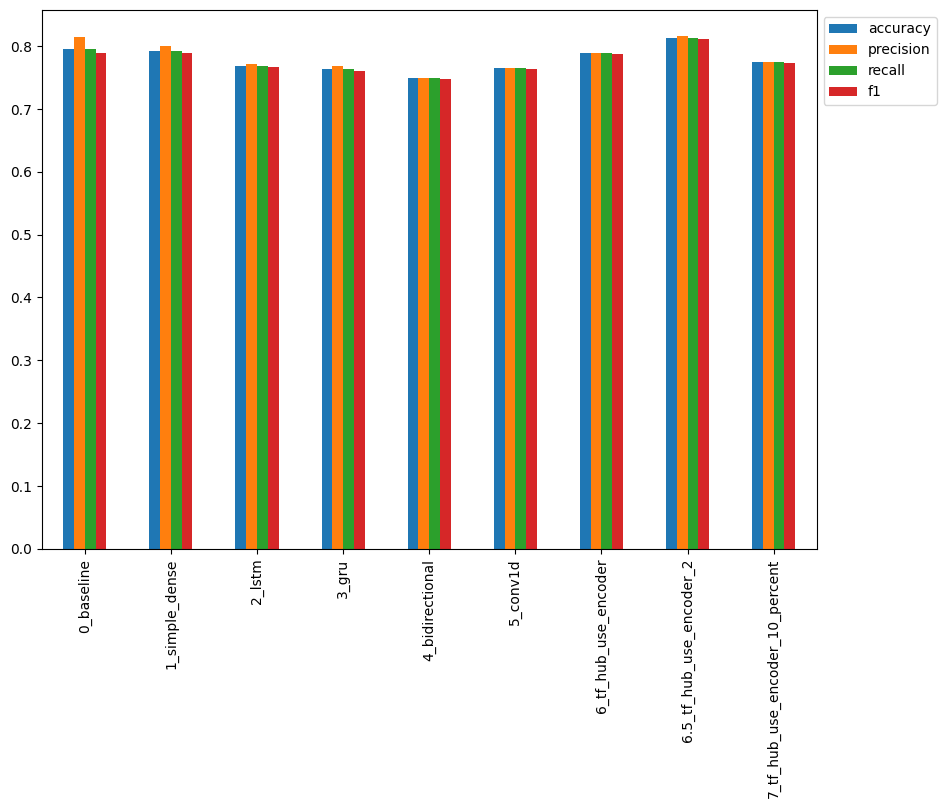

In [71]:
# Plot and compare all of the model results
all_model_results.plot(kind = 'bar', figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0))

<Axes: >

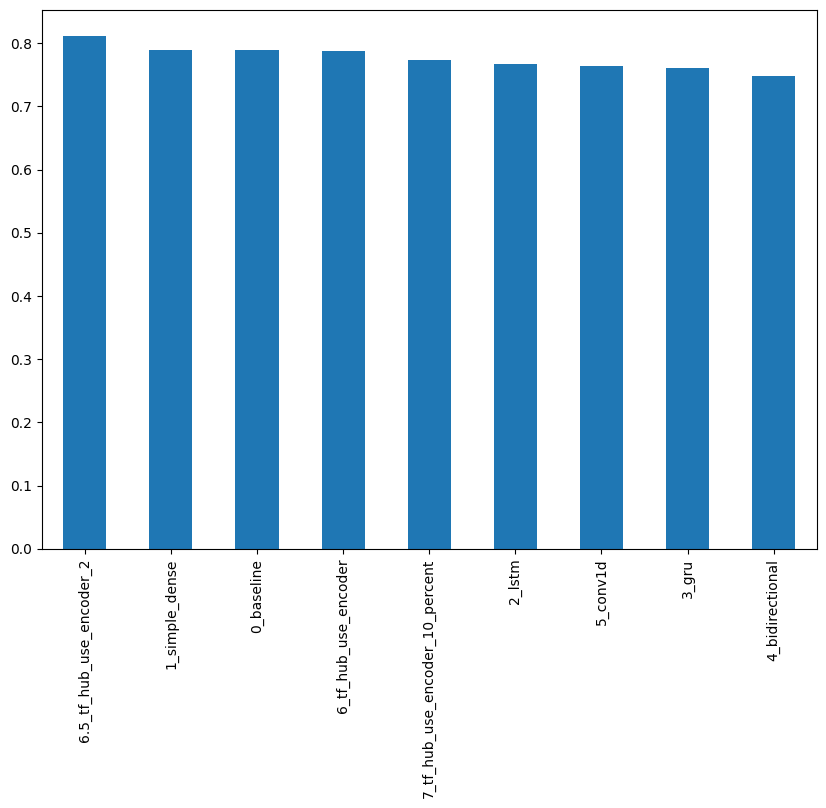

In [72]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending = False)['f1'].plot(kind = 'bar', figsize = (10, 7))

## Uploading Our Model Training Logs To TensorBoard.dev:
We can further inspect our models' performance using TensorBoard.dev: https://tensorboard.dev/

In [73]:
# View TensorBoard logs of transfer learning modeling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
    --name 'NLP Modeling Experiments ZTM TF Course Video' \
    --description 'Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset' \
    --one_shot # Exit the uploaded once uploading is finished

2025-10-17 11:02:05.953427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 11:02:14.393969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


Now that I've ran the cell above, my modeling experiments are visible on TensorBoard.dev:
https://...

📖 **Resource:** TensorBoard is great for quickly tracking experiments, but for larger scale experiments and a whole bunch more tracking options, check out Weights and Biases: https://wandb.ai/site

In [74]:
# See the previous TensorBoard Dev experiments you've run...
!tensorboard dev list

2025-10-17 11:06:55.512209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 11:07:34.620051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [75]:
# If you need to delete an experiment from TensorBoard, you can run the following:
#!tensorboard dev delete --experiment_id ...

## Saving And Loading A Trained Model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 Format
2. The .keras Format (this is the default when using Tensorflow)

In [77]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

In [80]:
# Load model with custom Hub Layer (required for HDF5 format)
import tensorflow_hub as hub
loaded_model_6_5 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects = {'KerasLayer': hub.KerasLayer})

In [81]:
# How does our loaded model perform?
loaded_model_6_5.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7887 - loss: 0.4935


[0.49347788095474243, 0.7887139320373535]

In [82]:
model_6_5_results

{'accuracy': 81.36482939632546,
 'precision': 0.8167324538978082,
 'recall': 0.8136482939632546,
 'f1': 0.8118519051176442}

Now let's save to the .keras format... (see more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load)

In [84]:
# Save TF Hub Sentence Encoder model to .keras format (default)
model_6_5.save('model_6_5_Keras_format.keras')

In [25]:
# Load in a model from the .keras format
loaded_model_6_5_keras_format = tf.keras.models.load_model('model_6_5_Keras_format.keras')

In [26]:
# Evaluate model in SavedModel format
loaded_model_6_5_keras_format.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8136 - loss: 0.4280


[0.42800670862197876, 0.8136482834815979]

## Finding The Most Wrong Examples:

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples, which ones is it getting *most* wrong (those whose prediction probabilities are closest to the opposite class)?

For example, if a sample should have a label of 0, but our model predicts a prediction probability of 0.999 (really close to 1), and vice versa.

In [24]:
# Create DataFrame with validation sentences, validation labels, and best performing model prediction labels + probabilities
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_5_preds,
                       'pred_prob': tf.squeeze(model_6_5_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.190019
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.832925
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.990259
3,@camilacabello97 Internally and externally scr...,1,0.0,0.190584
4,Radiation emergency #preparedness starts with ...,1,1.0,0.763563


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending = False)
most_wrong[:10] # These are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.939049
119,@freefromwolves GodsLove & #thankU brother Dan...,0,1.0,0.927440
759,FedEx will no longer transport bioterror patho...,0,1.0,0.911770
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.887914
628,@noah_anyname That's where the concentration c...,0,1.0,0.879817
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.878330
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.868167
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.832925
209,Ashes 2015: Australias collapse at Trent Bridg...,0,1.0,0.808727
698,MGN-AFRICA pin:263789F4 Correction: Tent Coll...,0,1.0,0.806971


In [ ]:
most_wrong.tail() # These are false negatives

,text,target,pred,pred_prob
221,going to redo my nails and watch behind the sc...,1,0.0,0.061189
233,I get to smoke my shit in peace,1,0.0,0.047038
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.040102
23,Ron & Fez - Dave's High School Crush https://t...,1,0.0,0.034886
38,Why are you deluged with low self-image? Take ...,1,0.0,0.033885


Let's remind ourselves of the target labels...
* 0 = not disaster
* 1 = disaster

In [27]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}. Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 0, Pred: 1.0. Prob: 0.9390491843223572
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0. Prob: 0.9274400472640991
Text:
@freefromwolves GodsLove & #thankU brother Danny for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake & Tsunami

----

Target: 0, Pred: 1.0. Prob: 0.9117699861526489
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0. Prob: 0.8879139423370361
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1.0. Prob: 0.8798169493675232
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0. Prob: 0.878329873085022
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http:

In [28]:
# Check the false positives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}. Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 1, Pred: 0.0. Prob: 0.0709013044834137
Text:
Reddit Will Now Quarantine_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

----

Target: 1, Pred: 0.0. Prob: 0.06519835442304611
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0.0. Prob: 0.0644804835319519
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0. Prob: 0.0635671466588974
Text:
I Will Survive by Gloria Gaynor (with Oktaviana Devi)  https://t.co/HUkJZ1wT36

----

Target: 1, Pred: 0.0. Prob: 0.06186477467417717
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0. Prob: 0.06118911877274513
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0. Prob: 0.04703808203339577
Text:
I get to smoke my shit in peace

----

Target: 1, Pr

## Making Predictions On The Test Dataset:

In [36]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].apply(clean_text).to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    #pred_prob = tf.squeeze(model_6_5.predict([test_sample])) # Our model expects a list as input
    pred_prob = tf.squeeze(model_6_5.predict(tf.constant([test_sample], dtype=tf.string))) #Actually, it expects a scalar string tensor
    pred = tf.round(pred_prob)
    print(f'Pred: {int(pred)}, Prob: {pred_prob}')
    print(f'Text\n{test_sample}\n')
    print('-----\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Pred: 0, Prob: 0.06032498925924301
Text
Tried my 1st #beastburger by #beyondmeat.  nowhere near what i thought based on hype. Drowned in ketchup wasnt bad but w/dijon it sucked.

-----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Pred: 1, Prob: 0.9601662755012512
Text
Police Officer Wounded Suspect Dead After Exchanging Shots: Richmond police officer wounded suspect killed a... http://t.co/YIKQRqczVZ

-----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Pred: 0, Prob: 0.3442372679710388
Text
8/5 Arizona Cardinals news: Jaron Brown makes headlines minor injuries continue to build http://t.co/QxKncvlrh1 http://t.co/KJnhNPMxGr

-----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Pred: 1, Prob: 0.7006014585494995
Text
I think Tsunami has hit the wall. Dang... #STLCards

-----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Pred: 0, Prob: 0.1738060563802719
Text
Emergency-response plan helps employees get back to productive work http://t.co/tXQZN6GTHa @BusInsMagazine

-----

1/1 

## Your Challenge... Predicting On Tweets From The Wild:

Go to your favorite Twitter (X) account and copy one of their latest Tweet (posts).

Then pass that Tweet (post) through our trained model.

Is that Tweet (post) a disaster or not a disaster (according to the model)? Is the model right or wrong?

## The Speed/Score Tradeoff:

In [37]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.
    """
    start_time = time.perf_counter() # Get start time
    model.predict(samples) # Make predictions
    end_time = time.perf_counter() # Get finish time
    total_time = end_time - start_time # Calculate how long perdictions took to make
    time_per_pred = total_time / len(samples)
    return total_time, time_per_pred

In [38]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_5_total_pred_time, model_6_5_time_per_pred = pred_timer(model = model_6_5,
                                                                samples = val_sentences)
model_6_5_total_pred_time, model_6_5_time_per_pred

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


(2.844498200000089, 0.0037329372703413244)

In [40]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.03418150000015885, 4.485761154876489e-05)

In [41]:
# Get results for model 6.5
model_6_5_results = calculate_results(y_true = val_labels,
                                      y_pred = model_6_5_preds)
model_6_5_results

{'accuracy': 81.23359580052494,
 'precision': 0.8124964136567949,
 'recall': 0.8123359580052494,
 'f1': 0.8116652178848713}

Text(0, 0.5, 'F1-score')

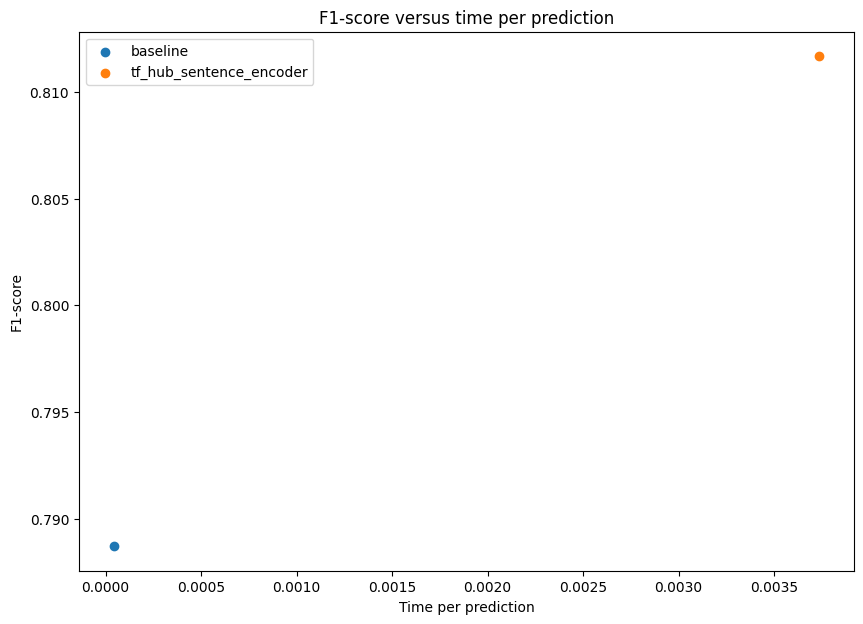

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label = 'baseline')
plt.scatter(model_6_5_time_per_pred, model_6_5_results['f1'], label = 'tf_hub_sentence_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score')